In [1]:
ls ../input/tech-gc/train_processed.csv

../input/tech-gc/train_processed.csv


In [2]:

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:

try:
    df_raw = pd.read_csv("data/train_processed.csv")
except:
    df_raw = pd.read_csv("../input/tech-gc/train_processed.csv")

In [4]:
def reduce_memory_usage(df):
    for col in df.columns:
        if df[col].dtype == "float64":
            df[col] = df[col].astype("float32")  # Reduce float64 → float32
        elif df[col].dtype == "int64":
            df[col] = df[col].astype("int32")  # Reduce int64 → int32
    return df

df_raw = reduce_memory_usage(df_raw)


In [5]:
df = df_raw

In [6]:
df1 = df.count() / df.shape[0] * 100
null_cols = df1[df1 == 0]
df = df.drop(columns = list(null_cols.index))
target_vars = [i for i in df.columns if 'target' in i]

In [7]:

feature_cols= [i for i in df.columns if i not in target_vars and i not in ['date_id','time_id','symbol_id', 'weight','symbol_category']]
target_vars = sorted(target_vars)

## Training

In [9]:
df = df_raw

In [10]:
# df = df_raw.copy()

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np

# Define the target, feature columns, and weight column
weight_column = 'weight'  # Column containing weights for each row
# df = df.fillna(0)
df.loc[:, 'symbol_category'] = df['symbol_id'].astype('category') #convert symbol to categorical


In [11]:
# Dictionary for training parameters
train_params = {
    'eval_metric': 'rmse',   
}

# # Dictionary for DMatrix and training configuration
# train_config = {
#     'verbose_eval': 10,                # Print progress every 10 rounds
#     'num_boost_round': 10,            # Number of boosting rounds     
#     'n_estimators': 40,      
# }

# # Dictionary for XGBRegressor parameters
# model_params = {
#     'objective': 'reg:squarederror',    # Task type (regression)
#     'enable_categorical': True,         # Enable categorical data handling
#     'verbosity': 1      ,                # Verbosity level
#     'learning_rate': 0.01,               # Learning rate
#     'n_estimators': 20,  # 🔥 Increase number of boosting rounds
#     'num_boost_round': 30,     
#     # 'max_depth': 6,                     # Max depth of trees
# }

train_params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.01,
    "eval_metric": "rmse"
}
train_config = {"num_boost_round": 120, 
                "verbose_eval": 20}

In [12]:
import numpy as np
import pandas as pd
import xgboost as xgb
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from abc import ABC, abstractmethod  # Abstract Base Class for models



# ------------------------------
# Base Model Class (Abstract)
# ------------------------------
class BaseModel(ABC):
    """Abstract Base Model Class defining the structure for any regression model."""

    @abstractmethod
    def train(self, X_train, y_train, w_train, X_val, y_val, w_val):
        pass

    @abstractmethod
    def predict(self, X, w, y_true):
        pass

    @staticmethod
    def weighted_r2_score(y_true, y_pred, weights):
        """Compute weighted R² score."""
        y_weighted_mean = np.sum(weights * y_true) / np.sum(weights)
        ss_res = np.sum(weights * (y_true - y_pred) ** 2)
        ss_tot = np.sum(weights * (y_true - y_weighted_mean) ** 2)
        return 1 - (ss_res / ss_tot) if ss_tot != 0 else 0  # Handle division by zero


# ------------------------------
# XGBoost Regressor Model
# ------------------------------
class XGBRegressorModel(BaseModel):
    def __init__(self, params, train_config):
        self.params = params
        self.train_config = train_config
        self.model = None  # Will store the trained model

    def train(self, X_train, y_train, w_train, X_val, y_val, w_val):
        """Train an XGBoost model using the given data."""
        dtrain = xgb.DMatrix(X_train, label=y_train, weight=w_train, enable_categorical=True, feature_names=list(X_train.columns))
        dtest = xgb.DMatrix(X_val, label=y_val, weight=w_val, enable_categorical=True)
        
        evals = [(dtrain, 'train'), (dtest, 'test')]

        self.model = xgb.train(
            params=self.params,
            dtrain=dtrain,
            evals=evals,
            **self.train_config
        )

    def predict(self, X, w, y_true):
        """Predict using the trained model and compute weighted RMSE & R²."""
        dtest = xgb.DMatrix(X, label=y_true, weight=w, enable_categorical=True)
        y_pred = self.model.predict(dtest)

        # Compute Weighted RMSE
        errors = (y_true - y_pred) ** 2
        weighted_mse = np.sum(w * errors) / np.sum(w)
        weighted_rmse = np.sqrt(weighted_mse)

        # Compute Weighted R²
        weighted_r2 = self.weighted_r2_score(y_true, y_pred, w)
        
        return weighted_rmse, weighted_r2


# ------------------------------
# Linear Regression Model
# ------------------------------
class LinearRegressorModel(BaseModel):
    def __init__(self):
        self.model = None  # Will store the trained model

    def train(self, X_train, y_train, w_train, X_val, y_val, w_val):
        """Train a Weighted Linear Regression model using statsmodels."""
        X_train = sm.add_constant(X_train)  # Add bias term
        self.model = sm.WLS(y_train, X_train, weights=w_train).fit()

    def predict(self, X, w, y_true):
        """Predict using the trained linear model and compute weighted RMSE & R²."""
        X = sm.add_constant(X)
        y_pred = self.model.predict(X)

        # Compute Weighted RMSE
        errors = (y_true - y_pred) ** 2
        weighted_mse = np.sum(w * errors) / np.sum(w)
        weighted_rmse = np.sqrt(weighted_mse)

        # Compute Weighted R²
        weighted_r2 = self.weighted_r2_score(y_true, y_pred, w)

        return weighted_rmse, weighted_r2


In [13]:
features = feature_cols + ['symbol_category']

In [14]:
MAXTIME = df['time_id'].max()
MAXTIME

848

In [15]:


# # ------------------------------
# # Walk-Forward Cross-Validation Loop
# # ------------------------------
# df = df_raw.copy()
# k = 4  # Number of models
# N_SPLIT = k + 1
# set_size = len(df) // (N_SPLIT + 1)
# weights = np.exp(np.linspace(0, 1, N_SPLIT - 1))
# weights /= np.sum(weights)
# row_weights = np.array(weights)  # Ensure weights are a NumPy array

# target_columns = target_vars[1:2]
# test_index = N_SPLIT * set_size
# features = feature_cols + ['symbol_category']

# use_xgboost = True
# # Select Model Type: Change to `LinearRegressorModel()` if needed
# if not(use_xgboost) :
#     df.fillna(0, inplace=True)

# model_class = XGBRegressorModel if use_xgboost else LinearRegressorModel

# # XGBoost Training Parameters
# # train_params = {
# #     "objective": "reg:squarederror",
# #     "learning_rate": 0.01,
# #     "eval_metric": "rmse"
# # }
# # train_config = {"num_boost_round": 100, "verbose_eval": 10}

# for target_column in target_columns:
#     train_r2, val_r2 = [], []
#     train_rmse, val_rmse = [], []

#     for j in tqdm(range(1, N_SPLIT), desc="Training"):
#         train_index = j * set_size
#         val_index = (j + 1) * set_size

#         X_train, X_val = df.loc[:train_index, features], df.loc[train_index:val_index, features]
#         y_train_target, y_val_target = df.loc[:train_index, target_column], df.loc[train_index:val_index, target_column]
#         w_train_target, w_val_target = df.loc[:train_index, weight_column], df.loc[train_index:val_index, weight_column]

#         # Train Model
#         model = model_class(train_params, train_config) if use_xgboost else model_class()
#         model.train(X_train, y_train_target, w_train_target, X_val, y_val_target, w_val_target)

#         # Predict & Evaluate
#         train_rmse_score, train_r2_score = model.predict(X_train, w_train_target, y_train_target)
#         val_rmse_score, val_r2_score = model.predict(X_val, w_val_target, y_val_target)

#         # Store weighted scores
#         # train_rmse.append(train_rmse_score * weights[j-1])
#         # val_rmse.append(val_rmse_score * weights[j-1])
#         # train_r2.append(train_r2_score * weights[j-1])
#         # val_r2.append(val_r2_score * weights[j-1])
#         train_rmse.append(train_rmse_score )
#         val_rmse.append(val_rmse_score )
#         train_r2.append(train_r2_score )
#         val_r2.append(val_r2_score )

#     # Final Test Set Evaluation
#     X_test, y_test_target = df.loc[test_index:, features], df.loc[test_index:, target_column]
#     w_test_target = df.loc[test_index:, weight_column]

#     test_rmse_score, test_r2_score = model.predict(X_test, w_test_target, y_test_target)

   
#     n_rows = len(train_r2)
    
#     # Store results in DataFrame
#     metrics_df = pd.DataFrame({
#         "Fold": [i for i in range(n_rows)],
#         "Train RMSE": train_rmse,
#         "Validation RMSE": val_rmse,
#         "Train R²": train_r2,
#         "Validation R²": val_r2,
#     })
    
#     # Convert "Fold" to object (allows both integers and strings)
#     metrics_df["Fold"] = metrics_df["Fold"].astype("object")
#     # Compute Mean Scores
#     # metrics_df.loc["Mean"] = metrics_df.mean()
    
    
    
#     metrics_df.loc[n_rows] = metrics_df.iloc[:].apply(lambda col: np.average(col, weights=row_weights), axis=0)
#     metrics_df.at[n_rows, "Fold"] = "Weighted mean"
    
    
    
#     # Add Final Test Scores
#     metrics_df.loc[n_rows+1] = {
#         "Fold": "Test",
#         "Train RMSE": np.nan,
#         "Validation RMSE": test_rmse_score,
#         "Train R²": np.nan,
#         "Validation R²": test_r2_score,
#     }
#     display(metrics_df)
#     metrics_df.to_csv(f"results_{target_column}.csv", index=True)


In [16]:
# m_xg120_lre2  = metrics_df.copy()
# m_xg120_lre2 

In [17]:
# m_lin = metrics_df.copy()
# m_lin

## Lag correlations

In [97]:
df.shape

(1682548, 89)

In [98]:
MAXTIME

848

In [99]:
features

['feature_00',
 'feature_01',
 'feature_02',
 'feature_03',
 'feature_04',
 'feature_05',
 'feature_06',
 'feature_07',
 'feature_08',
 'feature_09',
 'feature_10',
 'feature_11',
 'feature_12',
 'feature_13',
 'feature_14',
 'feature_15',
 'feature_16',
 'feature_17',
 'feature_18',
 'feature_19',
 'feature_20',
 'feature_22',
 'feature_23',
 'feature_24',
 'feature_25',
 'feature_28',
 'feature_29',
 'feature_30',
 'feature_32',
 'feature_33',
 'feature_34',
 'feature_35',
 'feature_36',
 'feature_37',
 'feature_38',
 'feature_39',
 'feature_40',
 'feature_41',
 'feature_42',
 'feature_43',
 'feature_44',
 'feature_45',
 'feature_46',
 'feature_47',
 'feature_48',
 'feature_49',
 'feature_50',
 'feature_51',
 'feature_52',
 'feature_53',
 'feature_54',
 'feature_55',
 'feature_56',
 'feature_57',
 'feature_58',
 'feature_59',
 'feature_60',
 'feature_61',
 'feature_62',
 'feature_63',
 'feature_64',
 'feature_65',
 'feature_66',
 'feature_67',
 'feature_68',
 'feature_69',
 'feature_

In [ ]:
from tqdm import tqdm

### unweighted

In [25]:
# Define lags to check
lags = [1, 2, 3, 4, 5]

lags.extend([i*MAXTIME for i in lags])

# Dictionary to store cross-correlation values
corr_dict = {}

target = 'target_1'
# Compute cross-correlation for each feature at different lags
for feature in tqdm(features):
    for lag in lags:
        shifted_feature = df[feature].shift(lag)
        correlation = df[target].corr(shifted_feature)  # Pearson correlation
        corr_dict[(feature, lag)] = correlation  # Store result




100%|██████████| 76/76 [00:30<00:00,  2.50it/s]


In [26]:

# Convert dictionary to DataFrame for sorting
print("Creating dataframe")
corr_df = pd.DataFrame(list(corr_dict.items()), columns=['Feature_Lag', 'Correlation'])
print("created df")

# Sort by absolute correlation (strongest relationships)
corr_df['Abs_Correlation'] = corr_df['Correlation'].abs()
corr_df = corr_df.sort_values(by='Abs_Correlation', ascending=False)


Creating dataframe
created df


In [28]:
corr_df.to_csv('corr_df.csv')
print("saved")

saved


In [29]:
# Select top-k correlated (feature, lag) pairs (e.g., top 10)
# top_k = 60
# top_feature_lag_pairs = corr_df.head(150)
top_feature_lag_pairs = corr_df
# top_feature_lag_pairs = corr_df[corr_df['Abs_Correlation']>0.3]
print(top_feature_lag_pairs.shape)
top_feature_lag_pairs

(760, 3)


,Feature_Lag,Correlation,Abs_Correlation
60,"(feature_06, 1)",-0.068362,0.068362
61,"(feature_06, 2)",-0.065441,0.065441
62,"(feature_06, 3)",-0.063923,0.063923
63,"(feature_06, 4)",-0.061283,0.061283
64,"(feature_06, 5)",-0.058542,0.058542
...,...,...,...
458,"(feature_49, 3392)",-0.000063,0.000063
109,"(feature_10, 4240)",0.000043,0.000043
66,"(feature_06, 1696)",0.000018,0.000018
230,"(feature_24, 1)",-0.000016,0.000016


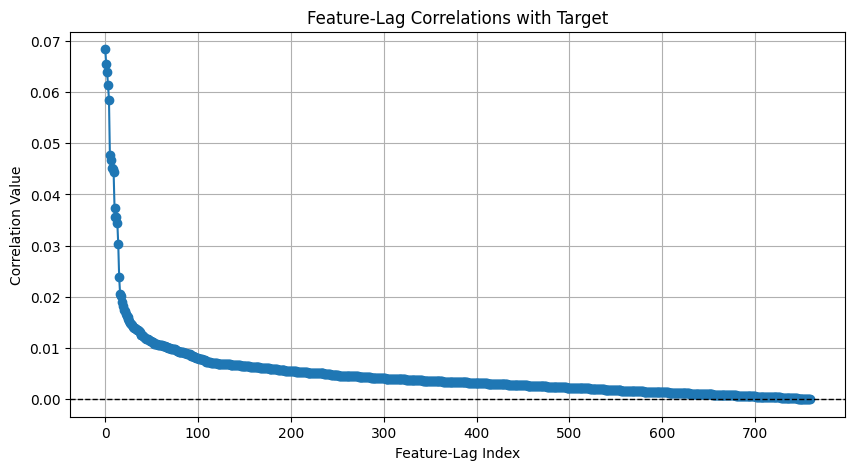

In [142]:
import matplotlib.pyplot as plt

# Extract correlation values
values = corr_df['Abs_Correlation'].values

# Plot
plt.figure(figsize=(10, 5))
plt.plot(values, marker='o', linestyle='-')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Add a zero reference line
plt.xlabel("Feature-Lag Index")
plt.ylabel("Correlation Value")
plt.title("Feature-Lag Correlations with Target")
plt.grid(True)
plt.show()


In [103]:
corr_df.shape

(760, 3)

In [138]:
# from tqdm import tqdm
# import numpy as np

# weights = df["weight"]  # Replace with actual weight column

# weighted_corr_dict = {}
# for feature in tqdm(features):
#     if feature[-2]<'05' or feature[-1]>'06':
#         continue
#     if feature == 'symbol_category':
#         continue
#     for lag in lags:
#         shifted_feature = df[feature].shift(lag)
#         print(feature,lag)

#         # Compute weighted mean
#         x_bar = np.average(shifted_feature, weights=weights)
#         y_bar = np.average(df[target], weights=weights)

#         # Compute numerator and denominator for weighted Pearson
#         num = np.sum(weights * (shifted_feature - x_bar) * (df[target] - y_bar))
#         denom_x = np.sqrt(np.sum(weights * (shifted_feature - x_bar) ** 2))
#         denom_y = np.sqrt(np.sum(weights * (df[target] - y_bar) ** 2))
#         print(num, denom_x, denom_y)

#         # Compute weighted correlation
#         correlation = num / (denom_x * denom_y) if denom_x * denom_y != 0 else 0
#         weighted_corr_dict[(feature, lag)] = correlation  # Store result
#     # break


## Creating the features

In [14]:
ls

In [7]:
ls

corr_df.csv


In [10]:
# df = df_raw

In [20]:
df.dtypes

date_id               int64
time_id               int64
symbol_id             int64
weight              float64
feature_00          float64
feature_01          float64
feature_02          float64
feature_03          float64
feature_04          float64
feature_05          float64
feature_06          float64
feature_07          float64
feature_08          float64
feature_09            int64
feature_10            int64
feature_11            int64
feature_12          float64
feature_13          float64
feature_14          float64
feature_15          float64
feature_16          float64
feature_17          float64
feature_18          float64
feature_19          float64
feature_20          float64
feature_22          float64
feature_23          float64
feature_24          float64
feature_25          float64
feature_28          float64
feature_29          float64
feature_30          float64
feature_32          float64
feature_33          float64
feature_34          float64
feature_35          

In [21]:
def reduce_memory_usage(df):
    for col in df.columns:
        if df[col].dtype == "float64":
            df[col] = df[col].astype("float32")  # Reduce float64 → float32
        elif df[col].dtype == "int64":
            df[col] = df[col].astype("int32")  # Reduce int64 → int32
    return df

df = reduce_memory_usage(df)


In [19]:
ls

In [21]:
ls ../input/correlation/

corr_df.csv


In [22]:
corr_df = pd.read_csv("../input/correlation/corr_df.csv")


In [23]:
corr_df.tail()

,Unnamed: 0,Feature_Lag,Correlation,Abs_Correlation
755,458,"('feature_49', 3392)",-0.000063,0.000063
756,109,"('feature_10', 4240)",0.000043,0.000043
757,66,"('feature_06', 1696)",0.000018,0.000018
758,230,"('feature_24', 1)",-0.000016,0.000016
759,734,"('feature_77', 5)",0.000008,0.000008


In [ ]:
# row = top_feature_lag_pairs.iloc[0]


In [ ]:
2

In [156]:
2

2

In [157]:
row

Feature_Lag        (feature_06, 1)
Correlation              -0.068362
Abs_Correlation           0.068362
Name: 60, dtype: object

In [161]:
row.Feature_Lag

('feature_06', 1)

In [30]:
# # Get the indices of the top 300,000 rows by weight
# top_300k_indices = df['weight'].nlargest(300000).index

# # Select these rows from the original DataFrame without changing order
# df_top_300k = df.loc[top_300k_indices]

# # Preserve the original order by sorting indices
# df_top_300k = df_top_300k.sort_index()

# # Check the shape
# print(df_top_300k.shape)  # Should be (300000, num_columns)


(300000, 89)


In [28]:
df_small = df.loc[:3*1e5,:]
df_small.shape

(300001, 93)

In [34]:
# lag_features = features.copy()

In [36]:
2

2

corr_df.csv


In [27]:
corr_df.head()

,Unnamed: 0,Feature_Lag,Correlation,Abs_Correlation
0,60,"('feature_06', 1)",-0.068362,0.068362
1,61,"('feature_06', 2)",-0.065441,0.065441
2,62,"('feature_06', 3)",-0.063923,0.063923
3,63,"('feature_06', 4)",-0.061283,0.061283
4,64,"('feature_06', 5)",-0.058542,0.058542


In [33]:
row = corr_df.iloc[0]
row

Unnamed: 0                        60
Feature_Lag        ('feature_06', 1)
Correlation                -0.068362
Abs_Correlation             0.068362
Name: 0, dtype: object

In [34]:
row.Feature_Lag

"('feature_06', 1)"

In [37]:
feature,lag = eval(row.Feature_Lag)[0]

'feature_06'

In [37]:
# corr_df[['Feature', 'Lag']] = pd.DataFrame(corr_df['Feature_Lag'].tolist(), index=corr_df.index)
corr_df[['Feature', 'Lag']] = corr_df['Feature_Lag'].apply(lambda x: pd.Series(eval(x)))
corr_df

,Unnamed: 0,Feature_Lag,Correlation,Abs_Correlation,Feature,Lag
0,60,"('feature_06', 1)",-0.068362,0.068362,feature_06,1
1,61,"('feature_06', 2)",-0.065441,0.065441,feature_06,2
2,62,"('feature_06', 3)",-0.063923,0.063923,feature_06,3
3,63,"('feature_06', 4)",-0.061283,0.061283,feature_06,4
4,64,"('feature_06', 5)",-0.058542,0.058542,feature_06,5
...,...,...,...,...,...,...
755,458,"('feature_49', 3392)",-0.000063,0.000063,feature_49,3392
756,109,"('feature_10', 4240)",0.000043,0.000043,feature_10,4240
757,66,"('feature_06', 1696)",0.000018,0.000018,feature_06,1696
758,230,"('feature_24', 1)",-0.000016,0.000016,feature_24,1


In [38]:
top_feature_lag_pairs = corr_df.head(150)
top_feature_lag_pairs

,Unnamed: 0,Feature_Lag,Correlation,Abs_Correlation,Feature,Lag
0,60,"('feature_06', 1)",-0.068362,0.068362,feature_06,1
1,61,"('feature_06', 2)",-0.065441,0.065441,feature_06,2
2,62,"('feature_06', 3)",-0.063923,0.063923,feature_06,3
3,63,"('feature_06', 4)",-0.061283,0.061283,feature_06,4
4,64,"('feature_06', 5)",-0.058542,0.058542,feature_06,5
5,40,"('feature_04', 1)",-0.047637,0.047637,feature_04,1
6,41,"('feature_04', 2)",-0.046638,0.046638,feature_04,2
7,42,"('feature_04', 3)",-0.045146,0.045146,feature_04,3
8,43,"('feature_04', 4)",-0.044972,0.044972,feature_04,4
9,44,"('feature_04', 5)",-0.044416,0.044416,feature_04,5


In [25]:
top_feature_lag_pairs.shape

(150, 4)

In [29]:
_df = df_small

In [31]:
row

NameError: name 'row' is not defined

In [35]:
# corr_df[['Feature', 'Lag']] = corr_df['Feature_Lag'].apply(lambda x: pd.Series(eval(x)))


,Unnamed: 0,Feature_Lag,Correlation,Abs_Correlation
0,60,"('feature_06', 1)",-0.068362,0.068362
1,61,"('feature_06', 2)",-0.065441,0.065441
2,62,"('feature_06', 3)",-0.063923,0.063923
3,63,"('feature_06', 4)",-0.061283,0.061283
4,64,"('feature_06', 5)",-0.058542,0.058542


In [40]:
df_small

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,target_0,target_3,target_4,target_5,target_6,target_7,target_1,target_8,target_2,symbol_category
0,170,0,0,2.112212,NaN,NaN,NaN,NaN,NaN,1.060330,1.515157,0.352634,-0.447763,11,7,76,-1.228861,0.008213,-0.601484,NaN,0.351496,NaN,-0.978721,-1.554902,0.674201,NaN,0.977276,0.720687,-1.718944,-0.776792,NaN,NaN,1.298210,-0.622460,0.129845,NaN,NaN,NaN,-0.242919,0.407667,0.995646,0.113174,-0.165448,NaN,-1.159101,NaN,NaN,-1.475422,NaN,NaN,NaN,4.592544,0.856289,1.457595,NaN,-0.299809,NaN,NaN,-0.467334,NaN,-1.898299,1.353400,NaN,0.741728,0.381551,-0.111088,NaN,NaN,NaN,NaN,NaN,-1.046170,0.287551,-0.465869,-1.249266,-0.353061,-0.944552,NaN,NaN,-0.218977,-0.304388,-0.272583,-0.421823,-0.293646,-0.061842,-0.305413,-0.419151,-0.111796,-0.535104,-0.044332,-0.039061,-0.744789,0
1,170,0,1,2.760715,NaN,NaN,NaN,NaN,NaN,0.482468,1.184037,0.171099,-0.247298,11,7,76,-1.369109,-0.025435,-0.572019,NaN,0.333387,NaN,-2.336337,-1.804332,0.482041,NaN,1.496122,1.238685,-1.272945,-0.684054,NaN,NaN,1.984172,-0.748950,-0.019552,NaN,NaN,NaN,0.332048,0.800314,1.780900,0.143083,-0.183142,NaN,1.752959,NaN,NaN,1.663024,NaN,NaN,NaN,2.421541,1.791842,1.813774,NaN,1.294006,NaN,NaN,-1.759731,NaN,-1.509075,1.277347,NaN,0.848605,0.271178,-0.111088,NaN,0.031604,-0.032718,NaN,NaN,-1.176612,0.035019,-0.675795,-1.018252,-0.092218,-0.677779,NaN,NaN,2.050337,1.861158,3.105997,3.111076,-0.075267,-0.359360,-1.270054,-0.018332,-0.040286,-1.417509,0.085840,0.487232,-0.124533,1
2,170,0,2,1.813596,NaN,NaN,NaN,NaN,NaN,1.020798,1.318752,0.398088,-0.247506,81,2,59,-1.202441,0.126689,-0.667604,NaN,1.618193,NaN,-1.923313,-1.489799,-0.390187,NaN,0.371769,-0.122028,-2.069380,-0.464404,NaN,NaN,0.847595,-0.523469,-0.272637,NaN,NaN,NaN,-1.744871,-1.437977,-2.215643,-0.720277,-0.699049,NaN,-3.051371,NaN,NaN,-3.332591,NaN,NaN,NaN,-1.343059,-0.003118,-1.028550,NaN,3.095362,NaN,NaN,0.718180,NaN,0.091084,2.605218,NaN,10.869972,4.770360,-0.111088,NaN,NaN,NaN,NaN,NaN,-0.637841,0.174133,-0.369733,-0.490952,0.059585,-0.718498,NaN,NaN,3.343488,3.539050,0.274703,0.458474,-5.000000,-5.000000,0.194658,-5.000000,-5.000000,-5.000000,1.583400,0.018712,-1.055035,2
3,170,0,3,0.926893,NaN,NaN,NaN,NaN,NaN,0.510098,0.645825,0.198428,-0.129691,4,3,11,-0.929123,-0.270122,-0.640521,NaN,0.086395,NaN,-1.066588,-1.175161,0.556984,NaN,-0.997101,-1.189861,-0.531423,1.408923,NaN,NaN,-0.964718,-0.776983,-0.565667,NaN,NaN,NaN,-1.574755,-1.067468,2.655016,-0.163804,0.170824,NaN,-1.407072,NaN,NaN,-2.000932,NaN,NaN,NaN,0.456696,-0.001778,0.822310,NaN,1.154819,NaN,NaN,1.109030,NaN,-1.734428,3.414650,NaN,-0.423668,-0.348209,-0.111088,6.384581,6.073787,4.517715,NaN,NaN,-0.972576,-0.128628,-0.793227,-0.979003,-0.456904,-0.686736,NaN,NaN,8.123117,11.267688,19.623468,17.805511,3.336086,2.051951,2.400644,0.962730,-0.939277,1.845870,-2.372452,-1.663179,-4.585349,3
4,170,0,7,1.665231,NaN,NaN,NaN,NaN,NaN,0.547458,1.009267,0.178444,-0.172451,11,7,76,-1.020558,0.547238,-0.840240,NaN,0.391496,NaN,-0.740257,-1.530828,1.008969,NaN,0.391344,0.294957,-0.790029,0.598666,NaN,NaN,0.497302,0.191926,0.424843,NaN,NaN,NaN,1.132698,1.018204,2.116459,0.005791,-0.09644

In [39]:
# Extract unique (Feature, Lag) pairs
feature_lag_pairs = top_feature_lag_pairs[["Feature", "Lag"]].values

# Dictionary to store new features
lag_features = {}

for feature, lag in tqdm(feature_lag_pairs, desc="Generating lag features"):
    # for _, row in tqdm(top_feature_lag_pairs.iterrows()):
    # feature = row['feature']
    # lag = row['lag']
    # feature,lag = row.Feature_Lag
    
    # Create lagged feature
    lagged_feature = _df[feature].shift(lag)
    lagged_feature_name = f"{feature}_lag{lag}"
    
    # Compute rolling mean & variance (window = lag)
    rolling_mean = lagged_feature.rolling(lag).mean()
    rolling_var = lagged_feature.rolling(lag).var()
    
    # Store results in dictionary
    lag_features[lagged_feature_name] = lagged_feature
    lag_features[f"{lagged_feature_name}_mean"] = rolling_mean
    lag_features[f"{lagged_feature_name}_var"] = rolling_var

# Convert dictionary to DataFrame and merge with original
lagged_df = pd.DataFrame(lag_features, index=_df.index)



Generating lag features: 100%|██████████| 150/150 [00:02<00:00, 50.70it/s]


In [47]:
_df = pd.concat([_df, lagged_df], axis=1)

In [48]:
_df.shape

(300001, 543)

In [49]:
# _df = df_small
lag_features = [i for i in _df.columns if i.split('_')[0] == 'feature']
lag_features.append('symbol_category')
lag_features

['feature_00',
 'feature_01',
 'feature_02',
 'feature_03',
 'feature_04',
 'feature_05',
 'feature_06',
 'feature_07',
 'feature_08',
 'feature_09',
 'feature_10',
 'feature_11',
 'feature_12',
 'feature_13',
 'feature_14',
 'feature_15',
 'feature_16',
 'feature_17',
 'feature_18',
 'feature_19',
 'feature_20',
 'feature_21',
 'feature_22',
 'feature_23',
 'feature_24',
 'feature_25',
 'feature_26',
 'feature_27',
 'feature_28',
 'feature_29',
 'feature_30',
 'feature_31',
 'feature_32',
 'feature_33',
 'feature_34',
 'feature_35',
 'feature_36',
 'feature_37',
 'feature_38',
 'feature_39',
 'feature_40',
 'feature_41',
 'feature_42',
 'feature_43',
 'feature_44',
 'feature_45',
 'feature_46',
 'feature_47',
 'feature_48',
 'feature_49',
 'feature_50',
 'feature_51',
 'feature_52',
 'feature_53',
 'feature_54',
 'feature_55',
 'feature_56',
 'feature_57',
 'feature_58',
 'feature_59',
 'feature_60',
 'feature_61',
 'feature_62',
 'feature_63',
 'feature_64',
 'feature_65',
 'feature_

In [167]:
len(lag_features)

526

In [168]:
df.shape

(1682548, 539)

## Training lag feature

In [46]:
len(lag_features)

1636

In [50]:
train_params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.01,
    "eval_metric": "rmse",
}
train_config = {"num_boost_round": 400, 
                "verbose_eval": 20,               
    "early_stopping_rounds": 20  # Stop if no improvement in 50 rounds
               }

In [49]:
# _df = df_small

In [51]:
# _features = feature_cols + ['symbol_category']
_features = lag_features

# ------------------------------
# Walk-Forward Cross-Validation Loop
# ------------------------------
k = 4  # Number of models
N_SPLIT = k + 1
set_size = len(_df) // (N_SPLIT + 1)
weights = np.exp(np.linspace(0, 1, N_SPLIT - 1))
weights /= np.sum(weights)
row_weights = np.array(weights)  # Ensure weights are a NumPy array

target_columns = target_vars[1:2]
test_index = N_SPLIT * set_size


use_xgboost = True
# Select Model Type: Change to `LinearRegressorModel()` if needed
if not(use_xgboost) :
    _df.fillna(0, inplace=True)

model_class = XGBRegressorModel if use_xgboost else LinearRegressorModel

# XGBoost Training Parameters
# train_params = {
#     "objective": "reg:squarederror",
#     "learning_rate": 0.01,
#     "eval_metric": "rmse"
# }
# train_config = {"num_boost_round": 100, "verbose_eval": 10}

for target_column in target_columns:
    train_r2, val_r2 = [], []
    train_rmse, val_rmse = [], []

    for j in tqdm(range(1, N_SPLIT), desc="Training"):
        train_index = j * set_size
        val_index = (j + 1) * set_size

        X_train, X_val = _df.loc[:train_index, _features], _df.loc[train_index:val_index, _features]
        y_train_target, y_val_target = _df.loc[:train_index, target_column], _df.loc[train_index:val_index, target_column]
        w_train_target, w_val_target = _df.loc[:train_index, weight_column], _df.loc[train_index:val_index, weight_column]

        # Train Model
        model = model_class(train_params, train_config) if use_xgboost else model_class()
        model.train(X_train, y_train_target, w_train_target, X_val, y_val_target, w_val_target)

        # Predict & Evaluate
        train_rmse_score, train_r2_score = model.predict(X_train, w_train_target, y_train_target)
        val_rmse_score, val_r2_score = model.predict(X_val, w_val_target, y_val_target)

        # Store weighted scores
        # train_rmse.append(train_rmse_score * weights[j-1])
        # val_rmse.append(val_rmse_score * weights[j-1])
        # train_r2.append(train_r2_score * weights[j-1])
        # val_r2.append(val_r2_score * weights[j-1])
        train_rmse.append(train_rmse_score )
        val_rmse.append(val_rmse_score )
        train_r2.append(train_r2_score )
        val_r2.append(val_r2_score )

    # Final Test Set Evaluation
    X_test, y_test_target = _df.loc[test_index:, _features], _df.loc[test_index:, target_column]
    w_test_target = _df.loc[test_index:, weight_column]

    test_rmse_score, test_r2_score = model.predict(X_test, w_test_target, y_test_target)

   
    n_rows = len(train_r2)
    
    # Store results in DataFrame
    metrics_df = pd.DataFrame({
        "Fold": [i for i in range(n_rows)],
        "Train RMSE": train_rmse,
        "Validation RMSE": val_rmse,
        "Train R²": train_r2,
        "Validation R²": val_r2,
    })
    
    # Convert "Fold" to object (allows both integers and strings)
    metrics_df["Fold"] = metrics_df["Fold"].astype("object")
    # Compute Mean Scores
    # metrics_df.loc["Mean"] = metrics_df.mean()
    
    
    
    metrics_df.loc[n_rows] = metrics_df.iloc[:].apply(lambda col: np.average(col, weights=row_weights), axis=0)
    metrics_df.at[n_rows, "Fold"] = "Weighted mean"
    
    
    
    # Add Final Test Scores
    metrics_df.loc[n_rows+1] = {
        "Fold": "Test",
        "Train RMSE": np.nan,
        "Validation RMSE": test_rmse_score,
        "Train R²": np.nan,
        "Validation R²": test_r2_score,
    }
    display(metrics_df)
    metrics_df.to_csv(f"results_{target_column}.csv", index=True)


Training:   0%|          | 0/4 [00:00<?, ?it/s]

[0]	train-rmse:0.95775	test-rmse:0.98204
[20]	train-rmse:0.92963	test-rmse:0.98320
[26]	train-rmse:0.92220	test-rmse:0.98463


Training:  25%|██▌       | 1/4 [00:10<00:31, 10.45s/it]

[0]	train-rmse:0.97015	test-rmse:0.97471
[20]	train-rmse:0.95248	test-rmse:0.97579
[25]	train-rmse:0.94839	test-rmse:0.97674


Training:  50%|█████     | 2/4 [00:26<00:27, 13.68s/it]

[0]	train-rmse:0.97176	test-rmse:1.01361
[20]	train-rmse:0.96005	test-rmse:1.01346
[37]	train-rmse:0.94937	test-rmse:1.01567


Training:  75%|███████▌  | 3/4 [00:49<00:18, 18.19s/it]

[0]	train-rmse:0.98211	test-rmse:0.76171
[19]	train-rmse:0.97164	test-rmse:0.76250


Training: 100%|██████████| 4/4 [01:12<00:00, 18.08s/it]
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Fold,Train RMSE,Validation RMSE,Train R²,Validation R²
0,0,0.921225,0.984811,0.077681,-0.005722
1,1,0.947550,0.976899,0.047924,-0.004488
2,2,0.949371,1.015673,0.046750,-0.004143
3,3,0.971094,0.762477,0.023626,-0.004395
4,Weighted mean,0.953387,0.906175,0.042461,-0.004532
5,Test,NaN,0.971854,NaN,-0.009325


In [52]:
feature_importance = model.model.get_score(importance_type='gain')  # or 'gain' or 'cover'


In [53]:
import pandas as pd

feature_importance_df = pd.DataFrame(
    list(feature_importance.items()), columns=["Feature", "Importance"]
).sort_values(by="Importance", ascending=False)

(feature_importance_df)


,Feature,Importance
1,feature_06,925.175720
14,feature_23,802.038696
63,feature_66_lag2_mean,682.446167
143,feature_05_lag848_mean,669.938538
124,feature_46_lag4240_var,602.865723
127,feature_67_lag848_var,574.407349
88,feature_28_lag3,563.707520
74,feature_58_lag4,562.333374
20,feature_37,550.944580
84,feature_66_lag5,523.547607


In [56]:
# feature_importance_df

In [57]:
feature_importance_df.head()

,Feature,Importance
1,feature_06,925.175720
14,feature_23,802.038696
63,feature_66_lag2_mean,682.446167
143,feature_05_lag848_mean,669.938538
124,feature_46_lag4240_var,602.865723


In [59]:
2

2

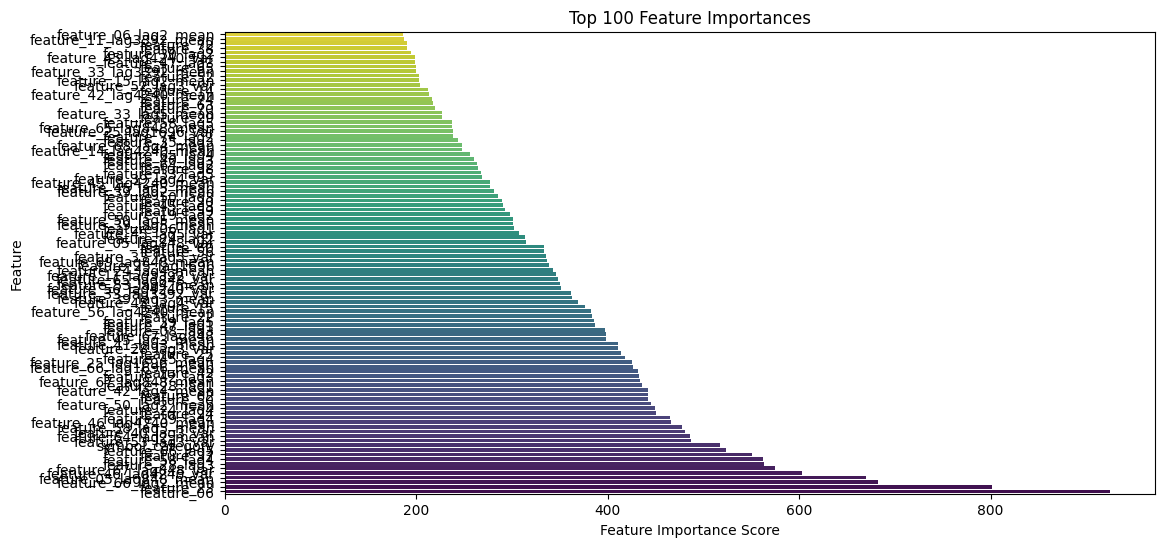

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the top 30 features
top_n = 100
plt.figure(figsize=(12, 6))
sns.barplot(
    x=feature_importance_df["Importance"][:top_n],
    y=feature_importance_df["Feature"][:top_n],
    palette="viridis",
)

plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title(f"Top {top_n} Feature Importances")
plt.gca().invert_yaxis()  # Invert y-axis to have most important at the top
plt.show()
